In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import Dataset, DataLoader
from mamba_ssm import Mamba
from torch_geometric.nn import GCNConv

# ============ Set Seed ============
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# ============ Dataset ============
import torch
from torch.utils.data import Dataset, DataLoader

class Twitter15Dataset(Dataset):
    def __init__(self, graph_data_list):
        """
        Args:
            graph_data_list (list): list of graphs, each graph is a dict {'x', 'edge_index', 'y'}
        """
        self.graphs = graph_data_list

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        graph = self.graphs[idx]
        x = graph['x']  # (seq_len, feature_dim)
        edge_index = graph['edge_index']  # (2, num_edges)
        y = graph['y']  # int64 label (0~3)

        return x, edge_index, y  # 返回3个元素！

def collate_fn(batch):
    xs, edge_indices, ys = zip(*batch)

    max_len = max(x.shape[0] for x in xs)  # find max sequence length in batch
    feature_dim = xs[0].shape[1]

    padded_xs = []
    masks = []
    edge_indices_new = []

    for i, (x, edge_index) in enumerate(zip(xs, edge_indices)):
        seq_len = x.shape[0]
        pad_len = max_len - seq_len

        if pad_len > 0:
            pad = torch.zeros((pad_len, feature_dim), dtype=x.dtype)
            x_padded = torch.cat([x, pad], dim=0)
        else:
            x_padded = x

        mask = torch.cat([torch.ones(seq_len), torch.zeros(pad_len)]).bool()

        padded_xs.append(x_padded)
        masks.append(mask)

        # 对 edge_index 做偏移（batch中每个graph单独编号）
        edge_index_offset = edge_index.clone()
        edge_index_offset += i * max_len
        edge_indices_new.append(edge_index_offset)

    padded_xs = torch.stack(padded_xs)    # (batch_size, max_len, feature_dim)
    masks = torch.stack(masks)             # (batch_size, max_len)
    ys = torch.tensor(ys)                  # (batch_size,)
    batch_edge_index = torch.cat(edge_indices_new, dim=1)  # (2, total_edges)

    return padded_xs, masks, batch_edge_index, ys

# ============ Model ============
# class GraphEncoder(nn.Module):
#     def __init__(self, hidden_dim):
#         super().__init__()
#         self.gcn = GCNConv(hidden_dim, hidden_dim)

#     def forward(self, x, edge_index):
#         """
#         Args:
#             x: (batch_size, max_len, hidden_dim)
#             edge_index: (2, total_edges) - already batch processed
#         """
#         batch_size, max_len, hidden_dim = x.size()

#         # Flatten x
#         x_flat = x.view(batch_size * max_len, hidden_dim)

#         if edge_index.numel() > 0:
#             h_flat = self.gcn(x_flat, edge_index)
#         else:
#             h_flat = x_flat

#         h = h_flat.view(batch_size, max_len, hidden_dim)
#         return h

class GraphEncoder(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.gcn = GCNConv(hidden_dim, hidden_dim)

    def forward(self, x, mask, edge_index):
        """
        x: (B, L, D)
        mask: (B, L) True=真实节点
        edge_index: (2, E) — 你拼好的大图
        """
        B, L, D = x.size()
        x_flat = x.view(B * L, D)                       # (B*L, D)

        # flatten mask
        mask_flat = mask.view(B * L)                    # (B*L,)
        mask_f   = mask_flat.unsqueeze(-1).to(x_flat.dtype)  

        # 先把 padding feature 确保为 0
        x_flat = x_flat * mask_f

        # GCN 卷积
        if edge_index.numel() > 0:
            h_flat = self.gcn(x_flat, edge_index)
        else:
            h_flat = x_flat

        # 再次把 padding 的输出置零
        h_flat = h_flat * mask_f

        # 恢复形状
        h = h_flat.view(B, L, D)
        return h


# class MambaEncoder(nn.Module):
#     def __init__(self, input_dim=833, hidden_dim=128, num_layers=2, dropout_rate=0.2):
#         super().__init__()
#         self.input_proj = nn.Linear(input_dim, hidden_dim)
#         self.layers = nn.ModuleList([
#             nn.Sequential(Mamba(d_model=hidden_dim), nn.Dropout(dropout_rate))
#             for _ in range(num_layers)
#         ])
#         self.norm = nn.LayerNorm(hidden_dim)

#     def forward(self, x, mask):
#         x = self.input_proj(x)
#         for layer in self.layers:
#             x = layer(x)
#         x = self.norm(x)
#         return x

class MambaLayer(nn.Module):
    def __init__(self, hidden_dim, dropout_rate):
        super().__init__()
        self.mamba   = Mamba(d_model=hidden_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # 只喂 x 给 Mamba
        x = self.mamba(x)
        x = self.dropout(x)
        return x


class MambaEncoder(nn.Module):
    def __init__(self, input_dim=833, hidden_dim=128, num_layers=2, dropout_rate=0.2):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        self.layers     = nn.ModuleList([
            MambaLayer(hidden_dim, dropout_rate)
            for _ in range(num_layers)
        ])
        self.norm       = nn.LayerNorm(hidden_dim)

    def forward(self, x, mask):
        """
        x:    (B, L, input_dim)
        mask: (B, L)   bool tensor, True 表示真实 token
        """
        # 1) 投影 + 首次屏蔽 padding
        x = self.input_proj(x)                          # -> (B, L, D)
        mask_f = mask.unsqueeze(-1).to(x.dtype)         # -> (B, L, 1)
        x = x * mask_f                                  # padding 位置全 0

        # 2) 每层 Mamba 后再屏蔽一次
        for layer in self.layers:
            x = layer(x)                                # Mamba + Dropout
            x = x * mask_f                              # 确保 padding 不累积噪声

        # 3) 归一化
        x = self.norm(x)
        return x

class MeanPooling(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, mask):
        mask = mask.unsqueeze(-1)
        x = x * mask
        sum_x = x.sum(dim=1)
        lengths = mask.sum(dim=1)
        pooled = sum_x / lengths.clamp(min=1e-6)
        return pooled

class ClassifierHead(nn.Module):
    def __init__(self, hidden_dim=128, num_classes=4):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

# class MambaClassifier(nn.Module):
#     def __init__(self, input_dim, hidden_dim, num_layers, num_classes):
#         super().__init__()
#         self.norm = nn.LayerNorm(input_dim)
#         self.encoder = MambaEncoder(input_dim, hidden_dim, num_layers)
#         self.gnn_encoder = GraphEncoder(hidden_dim)
#         self.pooling = MeanPooling()
#         self.classifier = ClassifierHead(hidden_dim, num_classes)

#     def forward(self, x, mask, edge_index):
#         x = self.norm(x)
#         h_seq = self.encoder(x, mask)
#         h_graph = self.gnn_encoder(h_seq, edge_index)
#         h = h_seq + 0.3 * h_graph
#         pooled = self.pooling(h, mask)
#         logits = self.classifier(pooled)
#         logits = torch.clamp(logits, min=-10, max=10)
#         return logits

class MambaClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes):
        super().__init__()
        self.norm        = nn.LayerNorm(input_dim)
        self.encoder     = MambaEncoder(input_dim, hidden_dim, num_layers)
        self.gnn_encoder = GraphEncoder(hidden_dim)
        self.pooling     = MeanPooling()
        self.classifier  = ClassifierHead(hidden_dim, num_classes)

    def forward(self, x, mask, edge_index):
        # x: (B, L, D), mask: (B, L), edge_index: (2, E)
        x = self.norm(x)
        h_seq   = self.encoder(x, mask)
        # 这里把 mask 一并传给 GCN
        h_graph = self.gnn_encoder(h_seq, mask, edge_index)
        h       = h_seq + 0.3 * h_graph
        pooled  = self.pooling(h, mask)
        logits  = self.classifier(pooled)
        return torch.clamp(logits, min=-10, max=10)

# ============ Loss Function ============
def smooth_cross_entropy(preds, targets, smoothing=0.1):
    confidence = 1.0 - smoothing
    logprobs = F.log_softmax(preds, dim=-1)
    nll_loss = -logprobs.gather(dim=-1, index=targets.unsqueeze(1)).squeeze(1)
    smooth_loss = -logprobs.mean(dim=-1)
    loss = confidence * nll_loss + smoothing * smooth_loss
    return loss.mean()

# ============ Training & Evaluation ============
def train_one_epoch(model, train_loader, optimizer, loss_fn, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for x, mask, edge_index, y in train_loader:
        x, mask, y = x.to(device), mask.to(device), y.to(device)
        edge_index = edge_index.to(device)  # edge_index也要.to(device)

        x = torch.nan_to_num(x, nan=0.0)

        optimizer.zero_grad()
        logits = model(x, mask, edge_index)
        logits = torch.clamp(logits, min=-10, max=10)  # clamp防爆

        if torch.isnan(logits).any() or torch.isinf(logits).any():
            continue  # 如果logits异常，跳过这个batch

        loss = loss_fn(logits, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item() * x.size(0)

        preds = logits.argmax(dim=-1)
        all_preds.extend(preds.detach().cpu().tolist())
        all_labels.extend(y.cpu().tolist())

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    epoch_f1 = f1_score(all_labels, all_preds, average='macro')

    return epoch_loss, epoch_acc, epoch_f1

def evaluate_one_epoch(model, val_loader, loss_fn, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, mask, edge_index, y in val_loader:
            x, mask, y = x.to(device), mask.to(device), y.to(device)
            edge_index = edge_index.to(device)

            logits = model(x, mask, edge_index)
            logits = torch.clamp(logits, min=-10, max=10)

            if torch.isnan(logits).any() or torch.isinf(logits).any():
                continue

            loss = loss_fn(logits, y)

            running_loss += loss.item() * x.size(0)

            preds = logits.argmax(dim=-1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(y.cpu().tolist())

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    epoch_f1 = f1_score(all_labels, all_preds, average='macro')

    return epoch_loss, epoch_acc, epoch_f1

class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0.0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_f1 = -float('inf')

    def __call__(self, val_f1, model, save_path):
        score = val_f1
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_f1, model, save_path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_f1, model, save_path)
            self.counter = 0

    def save_checkpoint(self, val_f1, model, save_path):
        torch.save(model.state_dict(), save_path)
        self.best_f1 = val_f1

import torch
from sklearn.model_selection import train_test_split
from torch.optim import AdamW

# ============ Set fixed parameters ============
batch_size = 32
hidden_dim = 128
num_layers = 2
num_classes = 4
max_epochs = 1000
patience = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ============ Load dataset ============
graph_data_list = torch.load("../processed/twitter15_graph_data_clean.pt", weights_only=False)

# split Train/Val/Test (7:1:1)
train_graphs, temp_graphs = train_test_split(graph_data_list, test_size=0.3, random_state=42)
val_graphs, test_graphs = train_test_split(temp_graphs, test_size=0.5, random_state=42)

print(f"Train: {len(train_graphs)}, Val: {len(val_graphs)}, Test: {len(test_graphs)}")

# Dataset
train_dataset = Twitter15Dataset(train_graphs)
val_dataset = Twitter15Dataset(val_graphs)
test_dataset = Twitter15Dataset(test_graphs)

# Dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# ============ Define hyperparameter grid ============
grid_params = {
    'lr': [5e-5, 3e-5, 1e-5],
    'weight_decay': [1e-2, 5e-2]
}

best_val_f1 = -float('inf')
best_params = None

# ============ Grid Search ============
for lr in grid_params['lr']:
    for wd in grid_params['weight_decay']:
        print(f"\n>>> Trying lr={lr}, weight_decay={wd}")

        # Model
        model = MambaClassifier(input_dim=833, hidden_dim=hidden_dim, num_layers=num_layers, num_classes=num_classes).to(device)
        optimizer = AdamW(model.parameters(), lr=lr, weight_decay=wd)
        loss_fn = smooth_cross_entropy
        early_stopper = EarlyStopping(patience=patience, verbose=True)

        save_path = "../checkpoints/best_model_v3_temp.pt"  # temp save

        # Train Loop
        for epoch in range(1, max_epochs + 1):
            train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
            val_loss, val_acc, val_f1 = evaluate_one_epoch(model, val_loader, loss_fn, device)

            print(f"Epoch {epoch}:")
            print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train F1: {train_f1:.4f}")
            print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f} | Val   F1: {val_f1:.4f}")

            early_stopper(val_f1, model, save_path)

            if early_stopper.early_stop:
                print("Early stopping triggered!")
                break

        print(f"Finished training with lr={lr}, weight_decay={wd}, Best Val F1={early_stopper.best_f1:.4f}")

        # Update best model
        if early_stopper.best_f1 > best_val_f1:
            best_val_f1 = early_stopper.best_f1
            best_params = {'lr': lr, 'weight_decay': wd}
            torch.save(model.state_dict(), "../checkpoints/best_model_v3.pt")  # overwrite best

# ============ Final report ============
print("\nGrid Search completed!")
print(f"Best Hyperparameters: {best_params}")
print(f"Best Validation Macro-F1: {best_val_f1:.4f}")

Train: 1043, Val: 223, Test: 224

>>> Trying lr=5e-05, weight_decay=0.01
Epoch 1:
  Train Loss: 1.3845 | Train Acc: 0.2464 | Train F1: 0.2141
  Val   Loss: 1.1884 | Val   Acc: 0.2199 | Val   F1: 0.1512


KeyboardInterrupt: 

### Step 5 Test Evaluation

Test Accuracy: 0.6429
Test Macro-F1: 0.6426


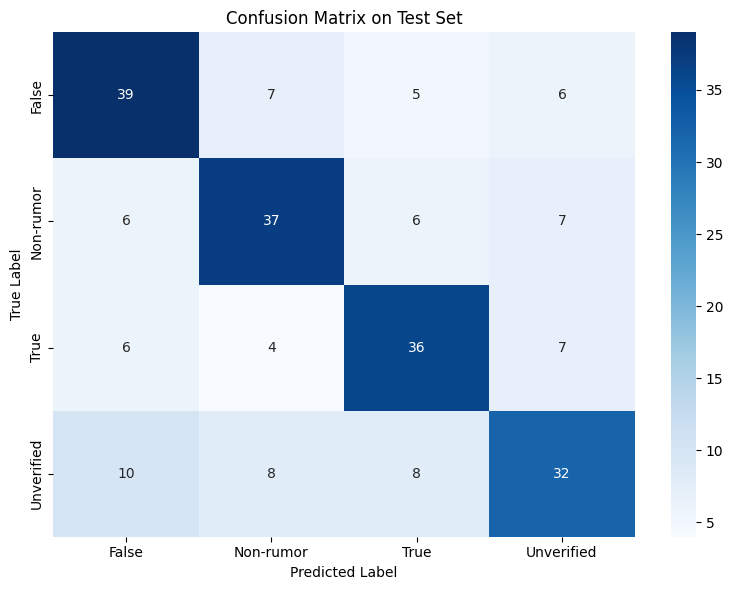

In [59]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# 1. Load the best model
model.load_state_dict(torch.load("../checkpoints/best_model_v3.pt"))
model.to(device)
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for x, mask, edge_index, y in test_loader:
        x = x.to(device)
        mask = mask.to(device)
        edge_index = edge_index.to(device)
        y = y.to(device)

        logits = model(x, mask, edge_index)
        preds = logits.argmax(dim=-1)

        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(y.cpu().tolist())

# 2. Compute Accuracy and F1
test_acc = accuracy_score(all_labels, all_preds)
test_f1 = f1_score(all_labels, all_preds, average='macro')

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Macro-F1: {test_f1:.4f}")

# 3. Plot Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True,
            xticklabels=["False", "Non-rumor", "True", "Unverified"],
            yticklabels=["False", "Non-rumor", "True", "Unverified"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on Test Set")
plt.tight_layout()
plt.show()